In [41]:
import numpy as np # linear algebra
import pandas as pd
import os
import json
import re, string
import sys
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

In [1]:
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [6]:
yelp_review = read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# yelp_review["date"] = pd.to_datetime(yelp_review["date"], format = "%Y-%m-%d")

In [7]:
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list]
    return filtered_words


def count_ngrams(lines, min_length=1, max_length=1):
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

## Gaussian fit

In [9]:
doc = yelp_review.text[0:10000]
review_length = []
for line in doc:
    words = tokenize(line)
#     print(words)
    review_length.append(len(words))
# print(review_length)

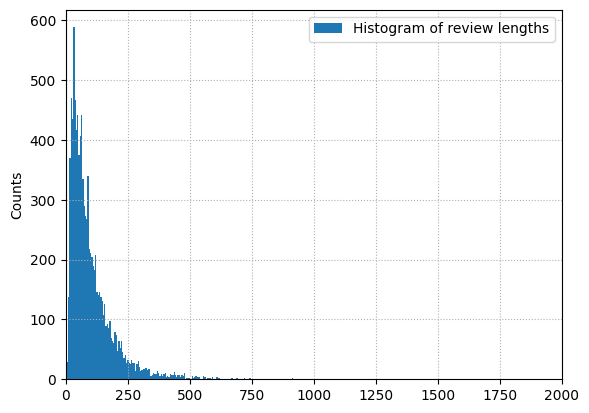

In [11]:
bins = 200

fig1, ax1 = plt.subplots()
#ax1.set_axisbelow(True)
ax1.set_xlim(0,2000)
(counts1,edges1, patches1) = plt.hist(review_length, bins, label="Histogram of review lengths")
plt.ylabel("Counts")
plt.legend(loc = 'upper right')
plt.grid(linestyle=':')
plt.show()

# plt.hist(review_length, bins = 200)
# plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 

In [53]:
mean = np.mean(review_length) 
sigma = np.std(review_length)
print(mean, sigma)
def GaussianFit(x, sigma, mean):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*(x-mean)**2/sigma**2)

103.4586 95.93550586743159


[   7.59   12.77   17.95   23.13   28.31   33.49   38.67   43.85   49.03
   54.21   59.39   64.57   69.75   74.93   80.11   85.29   90.47   95.65
  100.83  106.01  111.19  116.37  121.55  126.73  131.91  137.09  142.27
  147.45  152.63  157.81  162.99  168.17  173.35  178.53  183.71  188.89
  194.07  199.25  204.43  209.61  214.79  219.97  225.15  230.33  235.51
  240.69  245.87  251.05  256.23  261.41  266.59  271.77  276.95  282.13
  287.31  292.49  297.67  302.85  308.03  313.21  318.39  323.57  328.75
  333.93  339.11  344.29  349.47  354.65  359.83  365.01  370.19  375.37
  380.55  385.73  390.91  396.09  401.27  406.45  411.63  416.81  421.99
  427.17  432.35  437.53  442.71  447.89  453.07  458.25  463.43  468.61
  473.79  478.97  484.15  489.33  494.51  499.69  504.87  510.05  515.23
  520.41  525.59  530.77  535.95  541.13  546.31  551.49  556.67  561.85
  567.03  572.21  577.39  582.57  587.75  592.93  598.11  603.29  608.47
  613.65  618.83  624.01  629.19  634.37  639.55  6

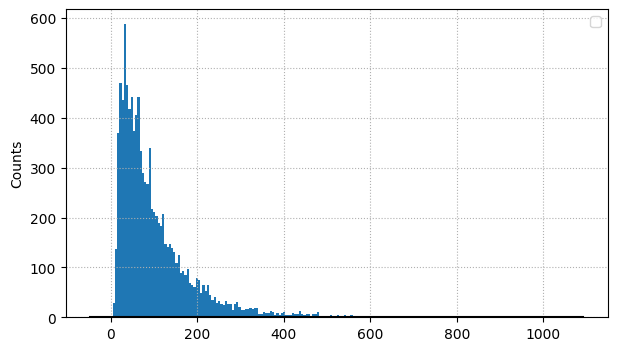

In [54]:
binscenters = np.array([0.5 * (edges1[i] + edges1[i+1])  for i in range(len(edges1)-1)])
print(binscenters)

# popt, pcov = curve_fit(GaussianFit, x1_data-x1_data[0],y1_data)
fig1, ax1 = plt.subplots(1,1,figsize=(7,4))
(counts1,edges1, patches1) = plt.hist(review_length, bins)
# plt.plot(GaussianFit(x,sigma,mean))
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max, 200)
p = norm.pdf(x,mean, sigma)
plt.plot(x,p, 'k')
plt.ylabel("Counts")
plt.legend(fontsize=10, loc='upper right')
plt.grid(linestyle=':')
plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 
plt.show()